In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parents[1]))

from ase.lattice.cubic import FaceCenteredCubic, SimpleCubic, BodyCenteredCubic
from ase.lattice.hexagonal import HexagonalClosedPacked
from ase.cluster.icosahedron import Icosahedron
from ase.cluster.decahedron import Decahedron
from ase.cluster.octahedron import Octahedron
from debyecalculator import DebyeCalculator
import torch
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
from ScattBO.utils import generate_structure, ScatterBO_small_benchmark, ScatterBO_large_benchmark

In [2]:
from bayes_opt import UtilityFunction, BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

In [3]:
def run_optimization(simulated_or_experimental='simulated', scatteringfunction='Gr', benchmark_size='small'):
    """
    Run the optimization process.

    Parameters:
    simulated_or_experimental (str): If 'simulated', use the filename 'Data/Gr/Target_PDF_small_benchmark.npy'. 
                                     If 'experimental', use the filename 'T2_0p7boro_15hrs_powder.npy'. Default is 'simulated'.
    scatteringfunction (str): The scattering function to use. 'Gr' for pair distribution function, 'Sq' for structure factor. Default is 'Gr'.
    benchmark_size (str): The size of the benchmark. 'small' for ScatterBO_small_benchmark, 'large' for ScatterBO_large_benchmark. Default is 'small'.
    """
    
    
    def benchmark_wrapper(pH, pressure, solvent):
        """
        Wrapper function for the ScatterBO benchmark function.
        """
        params = [pH, pressure, solvent]
        
        if benchmark_size == 'small':
            if scatteringfunction == 'both':
                return -ScatterBO_small_benchmark(params, plot=False, simulated_or_experimental=simulated_or_experimental, scatteringfunction='Gr') - \
                       ScatterBO_small_benchmark(params, plot=False, simulated_or_experimental=simulated_or_experimental, scatteringfunction='Sq')
            else:
                return -ScatterBO_small_benchmark(params, plot=False, simulated_or_experimental=simulated_or_experimental, scatteringfunction=scatteringfunction)
        elif benchmark_size == 'large':
            if scatteringfunction == 'both':
                return -ScatterBO_large_benchmark(params, plot=False, simulated_or_experimental=simulated_or_experimental, scatteringfunction='Gr') - \
                       ScatterBO_large_benchmark(params, plot=False, simulated_or_experimental=simulated_or_experimental, scatteringfunction='Sq')
            else:
                return -ScatterBO_large_benchmark(params, plot=False, simulated_or_experimental=simulated_or_experimental, scatteringfunction=scatteringfunction)
        else:
            raise ValueError("Invalid benchmark_size. Expected 'small' or 'large'.")

    # Define the domain for each parameter based on the benchmark size
    if benchmark_size == 'small':
        search_space = {'pH':(2,12),'pressure':(15,80), 'solvent':(0,1)}
    elif benchmark_size == 'large':
        search_space = {'pH':(0,14),'pressure':(0,100), 'solvent':(0,3)}
    else:
        raise ValueError("Invalid benchmark_size. Expected 'small' or 'large'.")

    print ("running BO optimisation")
    def final_wrapper(pH, pressure, solvent):

        solvent = int(solvent)
    
        return benchmark_wrapper(pH, pressure, solvent)
    if benchmark_size == 'small':
        optimizer = BayesianOptimization(
        f=final_wrapper,
        pbounds=search_space,
        verbose=2,
        random_state=129,
        allow_duplicate_points=True,
        )
        
        optimizer.set_gp_params(alpha=1e-2)

        optimizer.maximize(
            init_points=2,
            n_iter=40,
        
        )
    elif benchmark_size == 'large' and simulated_or_experimental == 'experimental' and scatteringfunction == 'Sq':
        optimizer = BayesianOptimization(
        f=final_wrapper,
        pbounds=search_space,
        verbose=2,
        random_state=128,
        allow_duplicate_points=True,
        )

        optimizer.set_gp_params(alpha=1e-2)

        optimizer.maximize(
            init_points=2,
            n_iter=46,
        
        )

    else:

        optimizer = BayesianOptimization(
        f=benchmark_wrapper,
        pbounds=search_space,
        verbose=2,
        random_state=8,
        )

        optimizer.set_gp_params(alpha=1e-2)

        optimizer.maximize(
            init_points=2,
            n_iter=48,
            
        )

    print ("Best parameters: ", optimizer.max)

    return optimizer

# Define the possible values for each parameter
simulated_or_experimental_values = ['simulated', 'experimental']
scatteringfunction_values = ['Gr', 'Sq','both']
benchmark_size_values = ['large','small'] # ['small', 'large']


Running optimization with simulated_or_experimental='simulated', scatteringfunction='Gr', benchmark_size='large'
running BO optimisation
|   iter    |  target   |    pH     | pressure  |  solvent  |
-------------------------------------------------------------


/Users/sjt972/Projects/ScattBO/src/ScattBO/utils/ScattBO.py:45: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled CPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc = DebyeCalculator(qmin=2, qmax=10.0, rmax=30, qstep=0.01)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/sjt972/Projects/ScattBO/src/ScattBO/Data/Gr/Target_PDF_benchmark.npy'

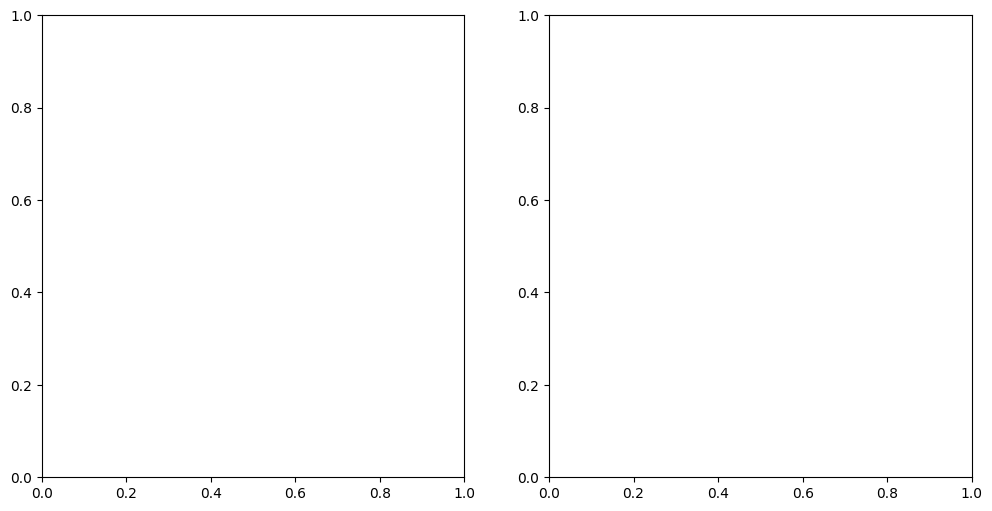

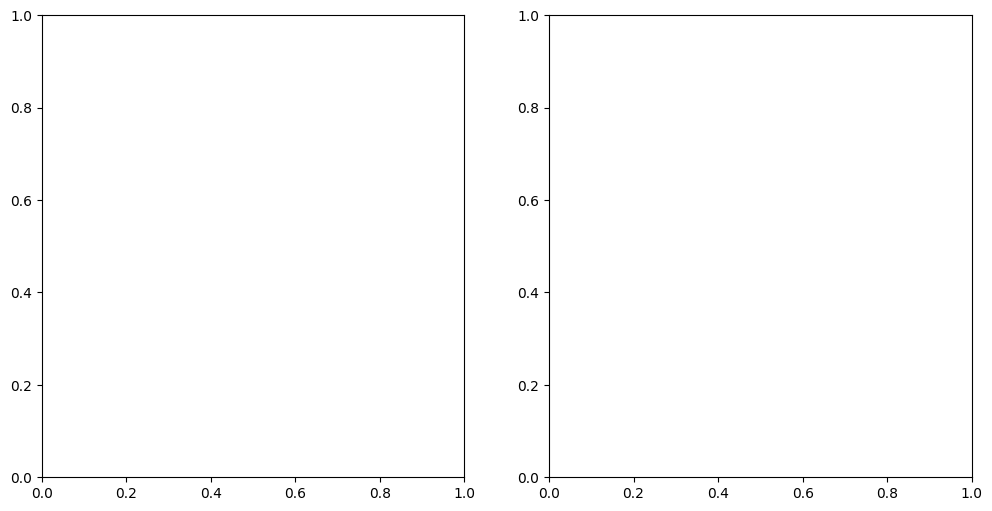

In [4]:
# Create a subplot with 2 plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig2, axs2 = plt.subplots(1, 2, figsize=(12, 6))
# Iterate over all possible combinations of parameters
for benchmark_size in benchmark_size_values:
    for simulated_or_experimental in simulated_or_experimental_values:
        for scatteringfunction in scatteringfunction_values:
            print(f"Running optimization with simulated_or_experimental='{simulated_or_experimental}', scatteringfunction='{scatteringfunction}', benchmark_size='{benchmark_size}'")
            optimizer = run_optimization(simulated_or_experimental=simulated_or_experimental, scatteringfunction=scatteringfunction, benchmark_size=benchmark_size)

            #Separation The iteration data into Iteration Number and Rwp values
            target  = optimizer.res
            Targets = dict()
            for i in range(len(target)):
                x = i+1
                Targets[x] = abs(target[i]['target'])
            Iterations = [key for key, value in Targets.items()]
            Rwp = [value for key, value in Targets.items()]

            #plot the convergence parameters for simulated and experimental
            if benchmark_size == 'large':
        
                if simulated_or_experimental == 'simulated':
                    
                    if scatteringfunction == 'Gr':
                        axs[0].plot(Iterations, Rwp, 'g', label ='Gr')
                    elif scatteringfunction == 'both':
                        axs[0].plot(Iterations, Rwp, 'b', label ='Gr & Sq')
                    else:
                        axs[0].plot(Iterations,Rwp,'orange',label ='Sq')

                    axs[0].set_title(f"{simulated_or_experimental.capitalize()} Data")
                else:
                    if scatteringfunction == 'Gr':
                        axs[1].plot(Iterations, Rwp, 'g', label ='Gr')
                    elif scatteringfunction == 'both':
                        axs[1].plot(Iterations, Rwp, 'b', label ='Gr & Sq')
                    else:
                        axs[1].plot(Iterations,Rwp,'orange',label ='Sq')

                    axs[1].set_title(f"{simulated_or_experimental.capitalize()} Data")
            
            elif benchmark_size == 'small':
                
                if simulated_or_experimental == 'simulated':
                    
                    if scatteringfunction == 'Gr':
                        axs2[0].plot(Iterations, Rwp, 'g', label ='Gr')
                    elif scatteringfunction == 'both':
                        axs2[0].plot(Iterations, Rwp, 'b', label ='Gr & Sq')
                    else:
                        axs2[0].plot(Iterations,Rwp,'orange',label ='Sq')

                    axs2[0].set_title(f"{simulated_or_experimental.capitalize()} Data")
                
                else:
                    
                    if scatteringfunction == 'Gr':
                        axs2[1].plot(Iterations, Rwp, 'g', label ='Gr')
                    elif scatteringfunction == 'both':
                        axs2[1].plot(Iterations, Rwp, 'b', label ='Gr & Sq')
                    else:
                        axs2[1].plot(Iterations,Rwp,'orange',label ='Sq')

                    axs2[1].set_title(f"{simulated_or_experimental.capitalize()} Data")


    axs[1].axhline(y=0.84, color='orange', linestyle='--', label="Success Criteria Experimental Sq Data (Rwp = 0.84)")
    axs[1].axhline(y=0.79, color='g', linestyle='--', label="Success Criteria Experimental Gr Data (Rwp = 0.79)")
    axs[1].legend()
    axs[1].set_xlabel("Steps")
    axs[1].set_ylabel("Rwp Value")

    axs[0].axhline(y=0.04, color='r', linestyle='--', label="Success Criteria SOBO (Rwp = 0.04)")
    axs[0].legend()
    axs[0].set_xlabel("Steps")
    axs[0].set_ylabel("Rwp Value")

    
    axs2[1].axhline(y=0.84, color='orange', linestyle='--', label="Success Criteria Experimental Sq Data (Rwp = 0.84)")
    axs2[1].axhline(y=0.79, color='g', linestyle='--', label="Success Criteria Experimental Gr Data (Rwp = 0.79)")
    axs2[1].legend()
    axs2[1].set_xlabel("Steps")
    axs2[1].set_ylabel("Rwp Value")

    axs2[0].axhline(y=0.04, color='r', linestyle='--', label="Success Criteria SOBO (Rwp = 0.04)")
    axs2[0].legend()
    axs2[0].set_xlabel("Steps")
    axs2[0].set_ylabel("Rwp Value")

fig.suptitle('Large_Benchmark')            
fig2.suptitle('Small_Benchmark')
plt.tight_layout()
fig.savefig('Bayes_Opt_large.png')
plt.show()